In [27]:
# Example-1-GP-BS-Pricing
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., Halperin I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020.

# Overview
The purpose of this notebook is to demonstrate the fitting of a Gaussian Process Regression model (GP) to option price data. In this notebook, European option prices are generated from the Black-Scholes model.  The notebook begins by building a GP call model, then a GP put model, and finally a portfolio holding which is short a put and long two calls. 

Note that the training sample size is set to 5 in order to illustrate the uncertainty bands. Seting the training sample size to a larger value, e.g. 50, will yield a much more accurate model.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
from BlackScholes import *
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import ConstantKernel, RBF


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Black-Scholes model parameters

In [29]:
r = 0.0002  # risk-free rate
S= 100      # Underlying spot
KC = 130    # Call strike
KP = 70     # Put strike
sigma = 0.4 # implied volatility
T = 2.0     # Time to maturity

In [30]:
# define the call and put prices using the BS model
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[0]

# GP Call pricer
Generate the training and testing data, where the input is the gridded underlying and the output are the option prices. Note that the inputs are scaled to the unit domain to aid interpretation and comparison of the hyper-parameters across different experiments.

In [31]:
lb = 0.001           # lower bound on domain
ub = 300             # upper bound on domain
training_number =5   # Number of training samples
testing_number = 100 # Number of testing samples

train_x_1 = np.array(np.linspace(0,1, training_number), dtype='float32').reshape(training_number, 1)
train_y_1 = []
for S in train_x_1:
    train_y_1.append(call(S))
    
test_x_1 = np.array(np.linspace(0,1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_1 = []
for S in test_x_1:
    test_y_1.append(call(S))

In [32]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))  #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_1,train_y_1)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=20,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [33]:
y_pred_1, sigma_1 = gp.predict(test_x_1, return_std=True)

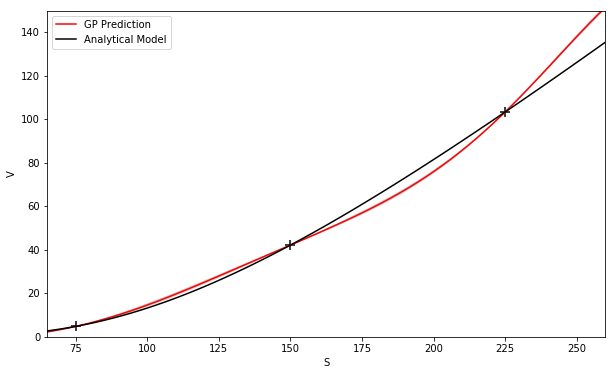

In [34]:
# predictionn plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), test_y_1, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_1, train_y_1, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KC/2.0,2.0*KC])
plt.ylim([0,150])
plt.xlabel('S')
plt.ylabel('V')

# GP Put pricer

In [35]:
train_x_2 = np.array(np.linspace(0,1, training_number), dtype='float32').reshape(training_number, 1)
train_y_2 = []
for S in train_x_2:
    train_y_2.append(put(S))
    
testing_number = 100
test_x_2 = np.array(np.linspace(0,1, testing_number), dtype='float32').reshape(testing_number, 1)
test_y_2 = []
for S in test_x_2:
    test_y_2.append(put(S))

In [36]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_2,train_y_2)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=20,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [37]:
y_pred_2, sigma_2 = gp.predict(test_x_2, return_std=True)

(0, 40)

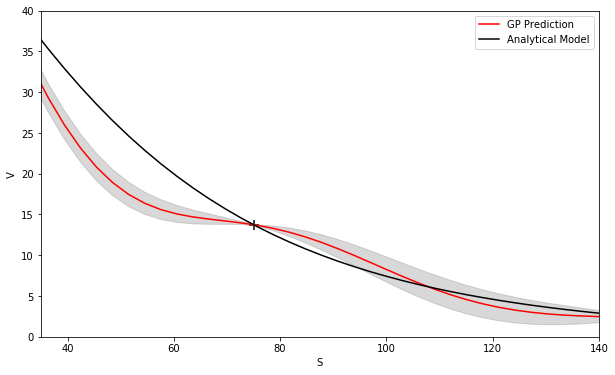

In [38]:
# prediction plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred_2, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y_2, color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_2.flatten(), train_y_2, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred_2.T-2*sigma_2).flatten(), (y_pred_2.T+2*sigma_2).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('S')
plt.ylabel('V')
plt.xlim([KP/2.0,2.0*KP])
plt.ylim([0,40])

# portfolio value

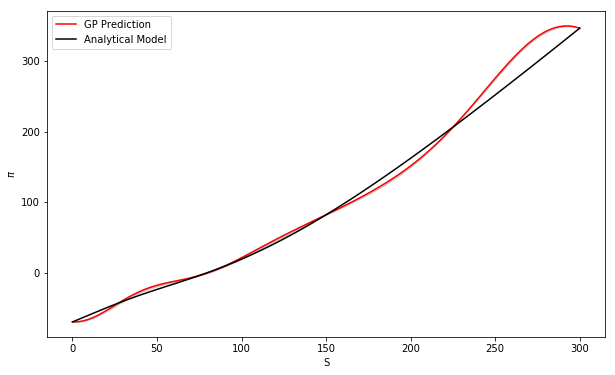

In [39]:
# portfolio prediction plot with var band 
y_pred = 2.0*y_pred_1 - y_pred_2 # long 2 calls and short a put
test_y = 2.0*np.array(test_y_1) - np.array(test_y_2)
sigma = np.sqrt(sigma_1*sigma_1 + sigma_2*sigma_2)
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), y_pred, color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*test_x_2.flatten(), test_y.flatten(), color = 'black', label = 'Analytical Model')
plt.fill_between(lb+(ub-lb)*test_x_2.flatten(), (y_pred.T-2*sigma).flatten(), (y_pred.T+2*sigma).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlabel('S')
plt.ylabel('$\pi$')